In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



## Part 1 ‐ Exploratory data analysis
<br>The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
# import the login data
login_time = pd.read_json('https://raw.githubusercontent.com/Floydworks/UltimateTechnologies/main/logins.json')

#login_time is a dataframe with a column of timestamps as the only values
login_time

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
# set timestamp as index
login_time.set_index('login_time', inplace=True)
login_time.sort_index(inplace=True)
#instantiate count column
login_time['count'] = 1
# Aggregate login counts based on 15minute time intervals
login_time_agg = login_time.resample("15min").sum()

print('Number of 15-minunte intervals: ', len(login_time_agg))
print('Total number of login observations: ', login_time_agg['count'].sum())
login_time_agg

Number of 15-minunte intervals:  9788
Total number of login observations:  93142


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [4]:
login_time_agg.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


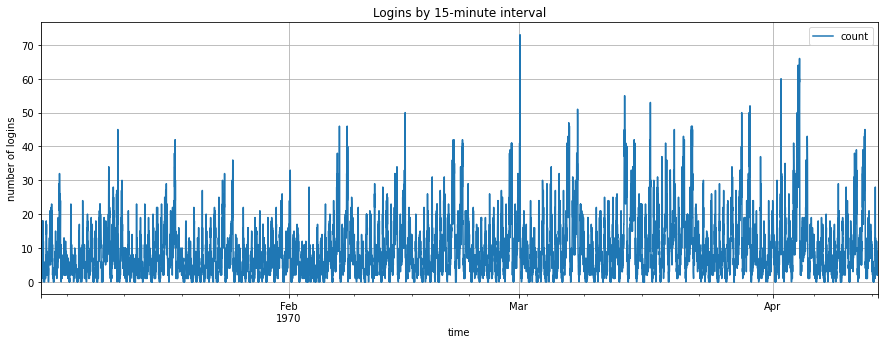

In [5]:
# plot visualization of data
login_time_agg.plot(figsize=(15,5), grid=True)
plt.title('Logins by 15-minute interval')
plt.xlabel('time')
plt.ylabel('number of logins')
plt.show()

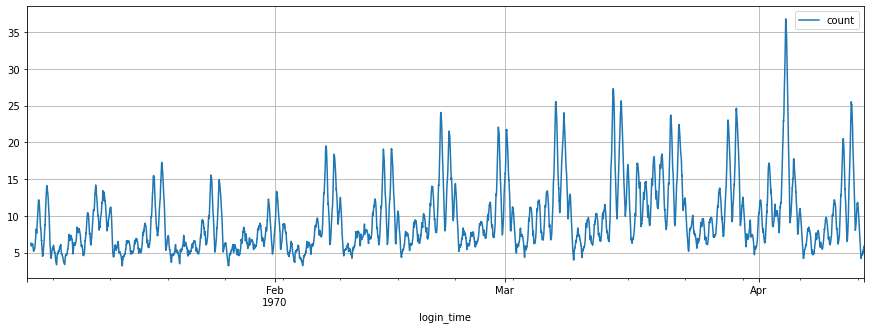

In [6]:
# with smoothing over 12 hour period
login_time_agg.rolling(window=48).mean().plot(figsize=(15,5), grid=True)
plt.show()

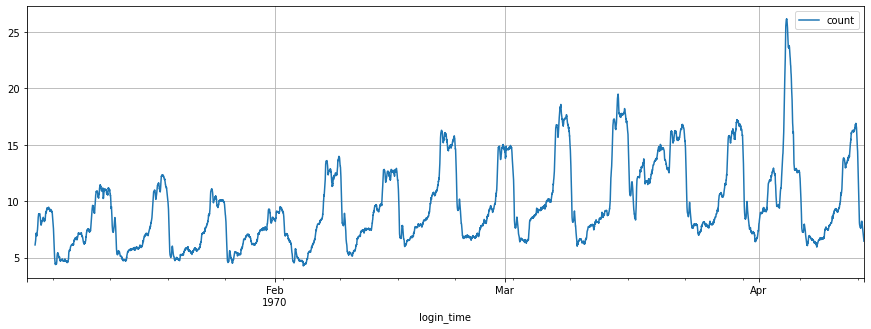

In [7]:
# with smoothing over a 24 hour period
login_time_agg.rolling(window=96).mean().plot(figsize=(15,5), grid=True)
plt.show()

**Summary of weekday pattern:**
<br>The minimum number of logins on a particular day is 0 and the maximum is 73. There is a pattern in the plot of 15-minute intervals. It seems like calls may go up at a certain time of the week, namely, the weekends. There is also some variation by month.

_____________
**Explore data by day of the week**

In [8]:
#add a day of the week column and move login_time to a column
login_time_agg_day = login_time_agg.reset_index()
#.rename(columns={login_time_agg.index.name:'login_time'})

#add columns with weekday number
login_time_agg_day['weekday_num'] = login_time_agg_day['login_time'].dt.dayofweek

# add column labeling days as weekend or weekday
weekday = []

for d in login_time_agg_day['weekday_num']:
    if d < 5:
        weekday.append("Weekday")
    else:  # 5 Sat, 6 Sun
        weekday.append("Weekend")
        
login_time_agg_day['weekday_text'] = weekday

login_time_agg_day.head(3)

,login_time,count,weekday_num,weekday_text
0,1970-01-01 20:00:00,2,3,Weekday
1,1970-01-01 20:15:00,6,3,Weekday
2,1970-01-01 20:30:00,9,3,Weekday


In [9]:
login_time_agg_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   login_time    9788 non-null   datetime64[ns]
 1   count         9788 non-null   int64         
 2   weekday_num   9788 non-null   int64         
 3   weekday_text  9788 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 306.0+ KB


In [10]:
# look at counts of logins by day of the week
daily_count = login_time_agg_day.groupby(login_time_agg_day['weekday_num']).sum().reset_index()
daily_count.head(7)

,weekday_num,count
0,0,8823
1,1,9268
2,2,10339
3,3,11960
4,4,15208
5,5,19377
6,6,18167


In [11]:
# get average logins on weekdays versus weekend days.
print('Average logins per weekday day: ',
    login_time_agg_day.groupby('weekday_text')['count'].sum()[0]/
    login_time_agg_day.groupby('weekday_text')['count'].count()[0])

print('Average logins per weekend day: ',
    login_time_agg_day.groupby('weekday_text')['count'].sum()[1]/
    login_time_agg_day.groupby('weekday_text')['count'].count()[1])


Average logins per weekday day:  8.048349739432542
Average logins per weekend day:  13.036111111111111


**Summary of weekday pattern:**
<br>When we count logins by weekday we can see that logins rise through the week and peak on Saturdays. Average number of logins on a weekday is approximately 8, while on a weekday the average increases to approximately 13. 

________
**Explore data by hour of the day**

In [12]:
login_time_agg_day['hour'] = login_time_agg_day['login_time'].dt.hour
login_time_agg_day

,login_time,count,weekday_num,weekday_text,hour
0,1970-01-01 20:00:00,2,3,Weekday,20
1,1970-01-01 20:15:00,6,3,Weekday,20
2,1970-01-01 20:30:00,9,3,Weekday,20
3,1970-01-01 20:45:00,7,3,Weekday,20
4,1970-01-01 21:00:00,1,3,Weekday,21
...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,0,Weekday,17
9784,1970-04-13 18:00:00,5,0,Weekday,18
9785,1970-04-13 18:15:00,2,0,Weekday,18
9786,1970-04-13 18:30:00,7,0,Weekday,18


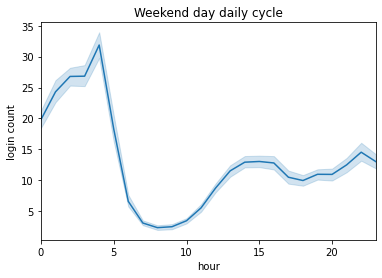

In [14]:
#Weekend daily cycles
weekend_df = login_time_agg_day[login_time_agg_day['weekday_text']=='Weekend']

sns.lineplot(x='hour', y='count', data=weekend_df)
plt.margins(x=0)
plt.title('Weekend day daily cycle')
plt.xlabel('hour')
plt.ylabel('login count')
plt.show()

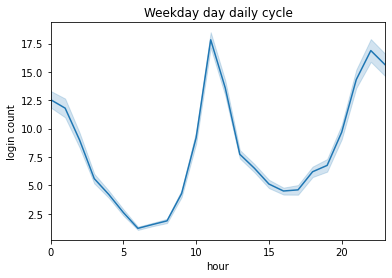

In [17]:
#weekday daily cycles
weekday_df = login_time_agg_day[login_time_agg_day['weekday_text']=='Weekday']

sns.lineplot(x='hour', y='count', data=weekday_df)
plt.margins(x=0)
plt.title('Weekday day daily cycle')
plt.xlabel('hour')
plt.ylabel('login count')
plt.show()

**Summary of hourly pattern:**
<br> On weekends, logins rise quickly after midnight and peak around 4am. On weekdays, logins peak around 11am and again around 10pm.

## Part 2 - Experiment and metrics design
<br>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a twoway toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

 - What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The simplest approach would be to compare the proportion of rides that feature a bridge crossing for drivers who do not have tolls reimbursed versus bridge crossings by drivers who do have tools reimbursed. The metric would be 
the number of rides across the bridge by driver i/total rides by driver i. This metric would be computed for each driver, the data would be grouped by treatment ('reimbursed' and 'toll'), and the groups would be compared.

 - Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment b. what statistical test(s) you will conduct to verify the significance of the observation c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**A. Experimental design:**
I would implement a pilot program for one month. Half of the drivers in each city would be randomly assigned to the control group ('toll'); their tolls would not be reimbursed during the testing period. The other half of the drivers in each city would have their tolls reimbursed ('reimbursed'). Because the cities have different use patterns throughout the day, I would split drivers by city rather than just assigninig half of all drivers to one or the other group. This would ensure an even number of treatment and control drivers from each location.

The experiment would run for a month, ideally a month when overall ridership is high. The experiment could be run for a shorter amount of time, but this may not allow drivers the time to change their patterns. A longer test period would also allow more drivers who use the reimbursements the opportunity to revert to staying in a single city if they do not like the program. If drivers use the program and then revert to not crossing the bridge, this could indicate a problem with the program that is not financial. The shorter test period has the advantage of providig results sooner.

<br>**B. Statistical tests:**
<br>The null hypothesis is that there will be no difference in the proportion of rides that are bridge crossings between the control ('toll') and treatment ('reimbursed') groups. 
<br>The alternative hypothesis is that the proportion of trips crossing the bridge will be higher for drivers who are in the treatment group ('reimbursed').
<br>Groups can be statistically compared using a number of tests. Because our sample sizes are fairly large, approximately 25,000 drivers per group, parametric tests such as the student's t-test  or Welch’s t-test (if variance is not similar) would probably suffice. If the data is not normally distributed, a non-parametric test such as a Mann–Whitney U test could be used to get statistical significance.
<br>The test can be two-tailed if we are uncertain of which direction the treatment group change would go. This would include the possibility that FEWER trips are made across the bridge when tolls are reimbursed. We really want to know if MORE trips are made across the bridge, so a one-tailed test would be more appropriate and a one-tailed approach is implied in out alternative hypothesis.

<br>**C. Interpretation:**
<br>The p-value associated with the group comparison would indicate wether or not to reject the null hypothesis. A typical threshold for significance is p < 0.05, meaning drivers are corssing the bridge more frequently when tolls are reimbursed. If the null hypothesis is rejected, the recommendation to the city would be to keep the program and assess it further. Further assessments would include wether or not drivers continue to cross the bridge over a longer period of testing and wether or not the change is enough to warrant the cost to the city.



## Part 3 ‐ Predictive modeling
<br>Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

 - 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

 - 2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

 - 3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

In [18]:
drivers = pd.read_json('https://raw.githubusercontent.com/Floydworks/UltimateTechnologies/main/ultimate_data_challenge.json')
drivers


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [19]:
drivers.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [20]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


**Data Summary**
<br>There are approximately 8000 missing values related to driver ratings. Since these values are not importnat 
right now to the experiment, we will keep the data with no need to interpo[late or fill those missing values.]

**Calculate driver retention**

In [21]:
drivers.last_trip_date = pd.to_datetime(drivers.last_trip_date)
drivers.signup_date = pd.to_datetime(drivers.signup_date)

In [22]:
drivers['last_trip_date'].describe()

/var/folders/bv/4mctz8d94zx0nlh0hjsm4x8h0000gn/T/ipykernel_36566/3786062231.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  drivers['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [23]:
active = (drivers.last_trip_date >= '2014-06-01').sum()
print('The number of drivers active in final month:', active)
count = len(drivers)
print('The number of drivers in 6-month assessment period: ',count)
fraction_retained = active / count
print('The percentage of drivers retained over period:', (round(fraction_retained*100)))

The number of drivers active in final month: 18804
The number of drivers in 6-month assessment period:  50000
The percentage of drivers retained over period: 38


**Look for correlations between retention and other features**

In [24]:
# create column with dummy variable for driver retained or not
drivers['retained'] = (drivers.last_trip_date >= '2014-06-01')*1


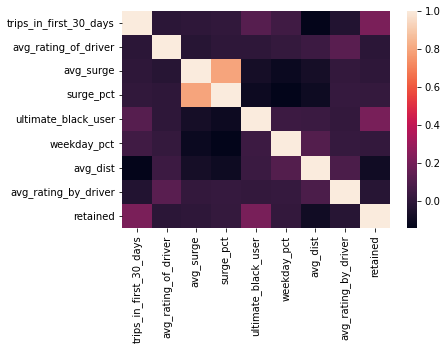

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
corr = drivers.corr()
ax = sns.heatmap(corr)
plt.show()

In [26]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: retained, dtype: float64

**Look at correlations between retention, city, and phone type**

In [27]:
# one-hot encode categorical columns
drivers_dum = pd.get_dummies(drivers, columns=['city', 'phone'])
drivers_dum.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


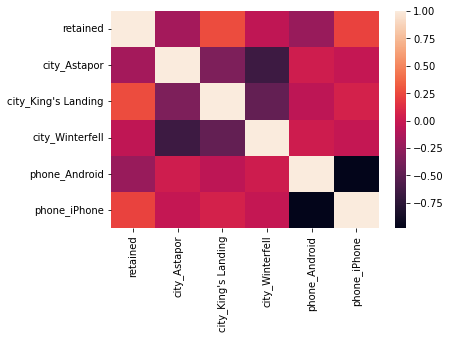

In [28]:
categoricals = drivers_dum.iloc[:,-6:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categoricals.corr()
ax = sns.heatmap(corr)
plt.show()

In [29]:
corr['retained'].sort_values(ascending=False)

retained               1.000000
city_King's Landing    0.262284
phone_iPhone           0.225244
city_Winterfell       -0.046611
city_Astapor          -0.174655
phone_Android         -0.225464
Name: retained, dtype: float64

**Corr plot summary:**
<br>Most features do not show much correlation. The features avg_surge and surge_pct are related as you might expect.
<br>If the driver is an ultimate_black_user they seem more likely to be retained and to have made trips in the first 30 days. 
<br>Making trips in the first 30 days appears to be somewhat correlated with retention. 
<br>King's Landing has a higher correlation with retention than other cities.
<br>iPhone users are retained more frequently than Android users and iPhone use appears to be higher in King's Landing.


## Build predictive models

In [41]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint


In [30]:
#reload the data
df = pd.read_json('https://raw.githubusercontent.com/Floydworks/UltimateTechnologies/main/ultimate_data_challenge.json')
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time

In [32]:
# create retained response
df['retained'] = (df.last_trip_date >= '2014-06-01')*1
#number of days until driver signed up
df.signup_date = pd.to_datetime(df.signup_date)
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,6,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


### address missing values

In [33]:
#look at missing values
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In [34]:
np.random.seed(0)

# fill missing phone type data
df.phone.fillna('other', inplace=True)

# one-hot encode categorical columns
df = pd.get_dummies(df, columns=['city', 'phone'])

#fill missing driver ratings
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

#df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  retained                50000 non-null  int64  
 11  city_Astapor            50000 non-null  uint8  
 12  city_King's Landing     50000 non-null  uint8  
 13  city_Winterfell         50000 non-null  uint8  
 14  phone_Android           50000 non-null

### Split and scale training and test data

In [36]:
#drop response variable and last_trip_date
X = df.drop(['retained', 'last_trip_date'], axis=1)
y = df['retained']

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [37]:
# scale X data sets
scale = StandardScaler()
scale.fit(X_train)
X_train_scaled = scale.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,0.450471,-1.779887,0.528532,-0.159448,-0.092318,-0.777450,1.053909,1.077871,0.272924,-0.703557,1.975034,-0.932006,-0.657890,0.670084,-0.088664
1,-0.335886,1.426400,-0.179838,-0.337924,-0.445329,1.286257,1.053909,1.283515,0.497352,-0.703557,1.975034,-0.932006,-0.657890,0.670084,-0.088664
2,7.003450,0.624828,0.528532,0.019029,-0.052542,1.286257,0.593080,-0.672742,0.048495,-0.703557,-0.506320,1.072955,1.520012,-1.492350,-0.088664
3,-0.073767,-1.207336,0.705624,-0.337924,-0.445329,-0.777450,-0.293544,1.872325,-1.746937,-0.703557,1.975034,-0.932006,1.520012,-1.492350,-0.088664
4,-0.598005,-0.291254,0.705624,-0.337924,-0.445329,-0.777450,1.053909,-0.140176,0.497352,-0.703557,1.975034,-0.932006,-0.657890,0.670084,-0.088664


In [38]:
X_test_scaled = scale.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_test_scaled.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,-0.598005,-1.207336,0.705624,-0.337924,-0.445329,-0.777450,1.053909,-0.820384,0.497352,-0.703557,-0.506320,1.072955,-0.657890,0.670084,-0.088664
1,0.188352,-1.321846,-0.888208,0.063648,0.797668,-0.777450,-0.630408,-0.006595,0.272924,1.421350,-0.506320,-0.932006,-0.657890,0.670084,-0.088664
2,0.712591,-1.207336,-0.002746,-0.337924,-0.445329,1.286257,0.638893,0.824770,-0.624792,-0.703557,-0.506320,1.072955,-0.657890,0.670084,-0.088664
3,0.188352,-0.520274,0.705624,-0.337924,-0.445329,1.286257,0.156505,-0.080416,0.497352,-0.703557,1.975034,-0.932006,1.520012,-1.492350,-0.088664
4,-0.598005,1.655420,0.705624,-0.337924,-0.445329,-0.777450,-1.640997,-0.743048,0.497352,-0.703557,-0.506320,1.072955,-0.657890,0.670084,-0.088664


### Fit models

In [39]:
#create a metrics table for storing metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest'])


In [42]:
# Instantiate the models/estimators
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_svm = SVC(random_state=0)
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)


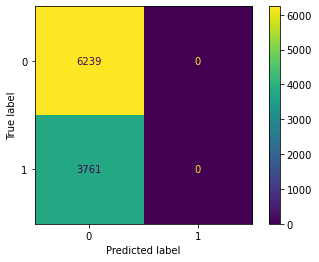

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      6239
           1       0.00      0.00      0.00      3761

    accuracy                           0.62     10000
   macro avg       0.31      0.50      0.38     10000
weighted avg       0.39      0.62      0.48     10000



/Users/sandidge/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandidge/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandidge/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


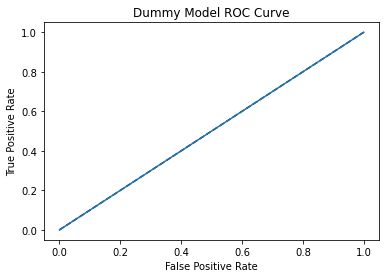

/Users/sandidge/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Dummy Model
dm = classifier_dm
dm.fit(X_train_scaled, y_train)
y_pred = dm.predict(X_test_scaled)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dm.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'Dummy Model'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)
    

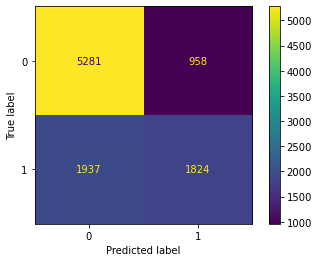

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      6239
           1       0.66      0.48      0.56      3761

    accuracy                           0.71     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.70      0.71      0.70     10000



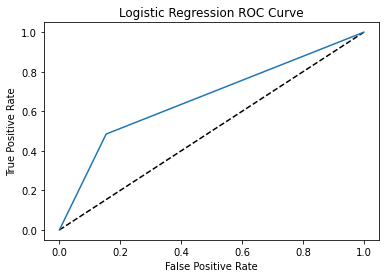

In [44]:
# Logistic Regression
lg = classifier_lr
lg.fit(X_train_scaled, y_train)
y_pred = lg.predict(X_test_scaled)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lg.classes_)
disp.plot()
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'Logistic Regression'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)
    


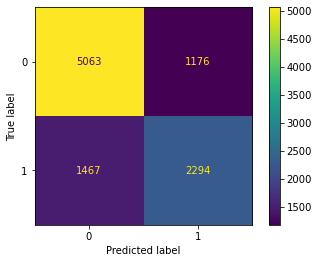

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      6239
           1       0.66      0.61      0.63      3761

    accuracy                           0.74     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.73      0.74      0.73     10000



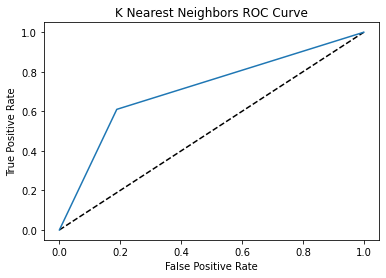

In [45]:
# fit KNN
t0 = time.time()
knn = classifier_knn
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
ttt = time.time() - t0 # ttt stands for "time to train"
metrics.loc['Time to Train', model_name] = ttt

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knn.classes_)
disp.plot()
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'K Nearest Neighbors'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)


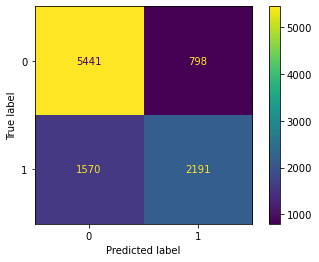

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      6239
           1       0.73      0.58      0.65      3761

    accuracy                           0.76     10000
   macro avg       0.75      0.73      0.74     10000
weighted avg       0.76      0.76      0.76     10000



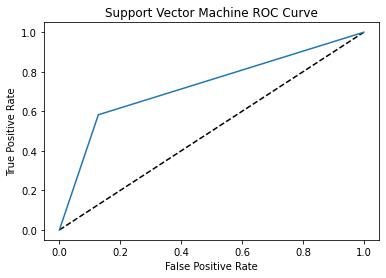

In [46]:
# fit SVM
t0 = time.time()
svm = classifier_svm
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
ttt = time.time() - t0 # ttt stands for "time to train"
metrics.loc['Time to Train', model_name] = ttt

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=svm.classes_)
disp.plot()
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'Support Vector Machine'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)
    

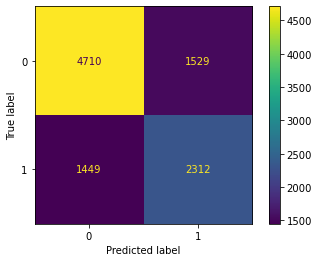

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6239
           1       0.60      0.61      0.61      3761

    accuracy                           0.70     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.70      0.70      0.70     10000



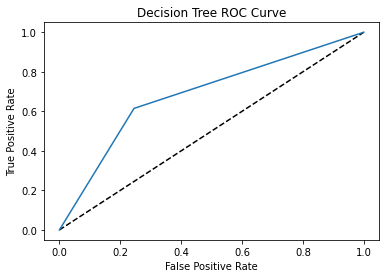

In [47]:
# fit Random Forest
t0 = time.time()
dt = classifier_dt
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
ttt = time.time() - t0 # ttt stands for "time to train"
metrics.loc['Time to Train', model_name] = ttt

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dt.classes_)
disp.plot()
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'Decision Tree'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)
    

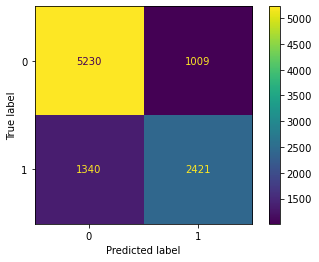

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6239
           1       0.71      0.64      0.67      3761

    accuracy                           0.77     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.76      0.77      0.76     10000



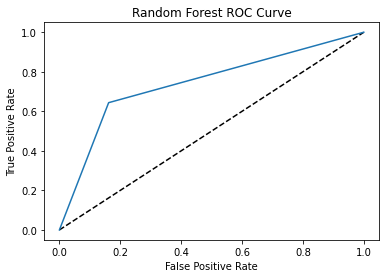

,importance
avg_dist,0.207980
signup_date,0.135630
weekday_pct,0.123081
avg_rating_by_driver,0.101377
surge_pct,0.077404
trips_in_first_30_days,0.072982
avg_rating_of_driver,0.072179
avg_surge,0.057879
city_King's Landing,0.047112
ultimate_black_user,0.033440


In [48]:
# fit Random Forest
t0 = time.time()
rf = classifier_rf
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
ttt = time.time() - t0 # ttt stands for "time to train"
metrics.loc['Time to Train', model_name] = ttt

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf.classes_)
disp.plot()
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# ROC Curve
model_name = 'Random Forest'
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % model_name)
plt.show()

#fill in metrics table
metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred)

pd.DataFrame(classifier_rf.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

**Data description:**
<br>city: city this user signed up in
<br>phone: primary device for this user
<br>signup_date: date of account registration; in the form ‘YYYYMMDD’
<br>last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
<br>avg_dist: the average distance in miles per trip taken in the first 30 days after signup
<br>avg_rating_by_driver: the rider’s average rating over all of their trips
<br>avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
<br>surge_pct: the percent of trips taken with surge multiplier > 1
<br>avg_surge: The average surge multiplier over all of this user’s trips
<br>trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
<br>ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
<br>weekday_pct: the percent of the user’s trips occurring during a weekday

In [49]:
# metrics table
metrics.astype(float).round(3)
actual_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
actual_metrics


,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest
accuracy,62.4,71.0,73.6,76.3,70.2,76.5
precision,0.0,65.6,66.1,73.3,60.2,70.6
recall,0.0,48.5,61.0,58.3,61.5,64.4
AUC,50.0,66.6,71.1,72.7,68.5,74.1


### Insights and recommendations

The Random Forest classifier was the best model. Accuracy was approximately 14 percent higher than the dummy model
which classified every driver as not-retained. The most important features in predicting retention were: 
- the average distance per trip
- signup date
- average percent of trips completed on weekdays
- average rating by driver

Retention may improve through the toll payment program as drivers will be able to take longer milage trips across the bridge.
    